In [0]:
!pip install biopython
from Bio import Entrez
from Bio import SeqIO
import numpy as np
import pickle
import pandas as pd
from collections import Counter
import matplotlib.pylab as plt


dataset_name="sequences_no_short_top_fams"


In [1]:
!python --version

Python 3.6.9


In [0]:
#Execute this cell to install your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Creating dataset

In [0]:
# !cp "/content/drive/My Drive/Colab Notebooks/gbvrlBase.seq" .
# !cp "/content/drive/My Drive/Colab Notebooks/Sequences" .
# !cp "/content/drive/My Drive/Colab Notebooks/sequence(1).gb" .

In [0]:
gb_file = "/content/drive/My Drive/Colab Notebooks/gbvrlBase.seq"
record = SeqIO.parse(open(gb_file,"r"), "genbank")
record_dict = SeqIO.to_dict(record)

In [0]:
families=[]
seqs=[]
type_seq=[]
full=[]
name=[]
for i in record_dict.keys():
    family=record_dict[i].annotations['taxonomy']
    type_molecule=record_dict[i].annotations["molecule_type"]
    if record_dict[i].features[0].qualifiers["mol_type"][0].startswith('genomic'):
        for j in family:
            if j.endswith("dae") and not j.startswith("unclassified") and not j.startswith("unassigned"):
                fam=j
                families.append(j)
                seqs.append(str(record_dict[i].seq))
                type_seq.append(type_molecule)
                full.append(record_dict[i])
                name.append(i)
 

In [0]:
out_file=open("sequences_filtered","wb")
pickle.dump((families,seqs,type_seq,name),out_file)

In [0]:
! cp sequences_filtered "drive/My Drive/Colab Notebooks/sequences_filtered"

# Reading dataset

In [0]:
! cp "drive/My Drive/Colab Notebooks/sequences_filtered" sequences_filtered

In [0]:
read_file=open("sequences_filtered","rb")
new_families,new_seqs,new_type_seq,names=pickle.load(read_file)
d={"Families":new_families,"Sequence":new_seqs,"Type sequence":new_type_seq,"Names":names}
df=pd.DataFrame(data=d)
len(df)

32201

In [0]:
df[df["Type sequence"]=="RNA"].groupby("Families").count().sort_values(by="Sequence",ascending=False)
df.groupby("Type sequence").count()

,Families,Sequence,Names
Type sequence,,,
DNA,19586,19586,19586
RNA,11983,11983,11983
ds-RNA,64,64,64
ss-DNA,3,3,3
ss-RNA,565,565,565


In [0]:
acum=0
aux=0
for i in df.groupby(["Families"]).count().sort_values(by=["Sequence","Type sequence"],ascending=False,axis=0)["Sequence"].values:
    acum+=i
    if acum/32201 > 0.9:
        break
    else:
        aux+=1
print("The families needed to take the {}% of the data is {}".format(round(acum/32201*100,2),aux))
df.groupby(["Families"]).count().sort_values(by=["Sequence","Type sequence"],ascending=False,axis=0)[:14]

The families needed to take the 90.7% of the data is 14


,Sequence,Type sequence,Names
Families,,,
Retroviridae,19066,19066,19066
Flaviviridae,3580,3580,3580
Herpesviridae,1516,1516,1516
Caliciviridae,974,974,974
Papillomaviridae,548,548,548
Reoviridae,535,535,535
Paramyxoviridae,440,440,440
Picornaviridae,437,437,437
Poxviridae,373,373,373


In [0]:
df["Length"]=df["Sequence"].apply(len) # get the length of each sequence
df["Letters"]=df["Sequence"].apply(set).apply(sorted) #get the letters that each sequence has and put it in an array
def inspeccion(x):
  result=True
  si_son=["A","C","T","N","G"]
  for i in range(len(x)):
    if x[i] not in si_son:
      return not result
    else:
      continue
  return result

def is_N_in(x):
  result=False
  for i in range(len(x)):
    if x[i]=="N":
      return not result
    else:
      continue
  return result

df_new=df[(~df["Letters"].apply(is_N_in)) & (df["Letters"].apply(inspeccion))].reset_index(drop=True)

In [0]:
lower_bound=100
acum=0
aux=0
total=df_new[df_new["Length"]>lower_bound].groupby(["Families","Type sequence"]).count().sum()[0]
for i in df_new[df_new["Length"]>lower_bound].groupby(["Families"]).count().sort_values(by=["Sequence","Type sequence"],ascending=False,axis=0)["Sequence"].values:
    acum+=i
    if acum/total > 0.9:
        break
    else:
        aux+=1
print("The families needed to take the {}% of the data is {}".format(round(acum/total*100,2),aux+1))
df_new[df_new["Length"]>lower_bound].groupby(["Families"]).count().sort_values(by=["Sequence","Type sequence"],ascending=False,axis=0)[:aux].sum()

The families needed to take the 90.11% of the data is 14


Sequence         26282
Type sequence    26282
Names            26282
Length           26282
Letters          26282
dtype: int64

In [0]:
families_size=aux+1
df_valid_length=df_new[df_new["Length"]>lower_bound].reset_index(drop=True)
frequent_families = df_valid_length.groupby('Families').count().sort_values(by=["Sequence","Type sequence"],ascending=False,axis=0)[:families_size]['Sequence'].keys()

df_viruses =df_valid_length[df_valid_length['Families'].isin(frequent_families)]
print(f"The new dataset consists of {families_size} families and covers {round(acum/total*100,2)}% of the data")
df_viruses.groupby(["Families"]).count()

The new dataset consists of 14 families and covers 90.11% of the data


,Sequence,Type sequence,Names,Length,Letters
Families,,,,,
Caliciviridae,884,884,884,884,884
Flaviviridae,3269,3269,3269,3269,3269
Hepadnaviridae,268,268,268,268,268
Herpesviridae,1274,1274,1274,1274,1274
Orthomyxoviridae,294,294,294,294,294
Papillomaviridae,529,529,529,529,529
Paramyxoviridae,419,419,419,419,419
Picornaviridae,329,329,329,329,329
Potyviridae,246,246,246,246,246


In [0]:
sequences = df_viruses["Sequence"]
families = df_viruses["Families"]

In [0]:
dataset_file=open(dataset_name,"wb")
pickle.dump((sequences, families),dataset_file)
!cp "$dataset_name" "drive/My Drive/Colab Notebooks/final/$dataset_name"

# Utils

In [0]:
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC

complexity=0.05

In [0]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize = (10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm


In [0]:
project_path = f"drive/My Drive/Colab Notebooks/final/"
dataset_path = f"{project_path}/{dataset_name}"
read_ds_file=open(dataset_path,"rb")
(sequences, families) = pickle.load(read_ds_file)

In [0]:
sequences.str.len().sort_values(ascending = False)[:15]

16629    230278
21843    229354
23690    223666
15696    190289
24617    186986
22362    185578
9196     184439
20935    177923
21424    172281
4891     162519
4895     162493
4877     162492
4886     162490
4887     162490
4876     162488
Name: Sequence, dtype: int64

In [0]:
d={"Sequences":np.array(sequences),"Families":np.array(families)}
data=pd.DataFrame(d).drop_duplicates("Sequences")
vc=data["Families"].value_counts()
filter_data=vc[vc>200].index.tolist()
data=data[data["Families"].isin(filter_data)]
families=data["Families"].reset_index(drop=True)
sequences =data["Sequences"].reset_index(drop=True)

# Classification _n-grams_

### Making the dataset

In [0]:
seqs_train, seqs_test, fams_train, fams_test = train_test_split(sequences, families, test_size=0.2)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer="char", ngram_range=(4,6), lowercase=True)
cv.fit(sequences)
len(cv.get_feature_names())

5376

In [0]:
seqs_train_vect = cv.transform(seqs_train).toarray()
seqs_test_vect = cv.transform(seqs_test).toarray()

In [0]:
# seqs_train_vect = normalize(seqs_train_vect, norm='l1', axis=1).toarray()
# seqs_test_vect = normalize(seqs_test_vect, norm='l1', axis=1).toarray()

In [0]:
from sklearn.preprocessing import StandardScaler

standardizer = StandardScaler()
seqs_train_vect = standardizer.fit_transform(seqs_train_vect)
seqs_test_vect = standardizer.transform(seqs_test_vect)

In [0]:
# Size of test an train datasets
print(f"train: dataset {len(seqs_train_vect)}")
print(f"test: dataset {len(seqs_test_vect)}")

train: dataset 18359
test: dataset 4590


### Training the model

In [0]:
linear_svm = LinearSVC(C=complexity, max_iter=5000, tol=1e-5)
linear_svm.fit(seqs_train_vect, fams_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.05, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=None, tol=1e-05,
          verbose=0)

### Saving the model 

In [0]:
svm_ng_path = f"{project_path}/svm_ng.pkl"
svm_ng_file = open(svm_ng_path,"wb")
pickle.dump(linear_svm, svm_ng_file)

In [0]:
svm_ng_path = f"{project_path}/svm_ng.pkl"
svm_ng_file = open(svm_ng_path,"rb")
linear_svm = pickle.load(svm_ng_file)

### Classifying

In [0]:
train_prediction = linear_svm.predict(seqs_train_vect)
test_prediction= linear_svm.predict(seqs_test_vect)

In [0]:
print(classification_report(fams_test, test_prediction))

                  precision    recall  f1-score   support

   Caliciviridae       0.98      0.98      0.98        93
    Flaviviridae       0.98      1.00      0.99       591
  Hepadnaviridae       1.00      0.96      0.98        54
   Herpesviridae       0.92      0.89      0.91       190
Orthomyxoviridae       1.00      0.91      0.95        56
Papillomaviridae       0.99      0.97      0.98        98
 Paramyxoviridae       0.99      0.95      0.97        77
  Picornaviridae       0.96      0.90      0.93        72
     Potyviridae       0.95      0.98      0.97        43
      Poxviridae       0.98      0.88      0.93        72
      Reoviridae       0.97      0.96      0.97       108
    Retroviridae       0.99      1.00      1.00      3035
   Rhabdoviridae       1.00      0.95      0.97        57
     Togaviridae       0.95      0.95      0.95        44

        accuracy                           0.99      4590
       macro avg       0.98      0.95      0.96      4590
    weighted

In [0]:
print(classification_report(fams_train, train_prediction))

                  precision    recall  f1-score   support

   Caliciviridae       1.00      1.00      1.00       485
    Flaviviridae       1.00      1.00      1.00      2226
  Hepadnaviridae       1.00      1.00      1.00       200
   Herpesviridae       1.00      1.00      1.00       813
Orthomyxoviridae       1.00      1.00      1.00       225
Papillomaviridae       1.00      1.00      1.00       378
 Paramyxoviridae       1.00      1.00      1.00       303
  Picornaviridae       1.00      1.00      1.00       241
     Potyviridae       1.00      1.00      1.00       200
      Poxviridae       1.00      1.00      1.00       283
      Reoviridae       1.00      1.00      1.00       360
    Retroviridae       1.00      1.00      1.00     12228
   Rhabdoviridae       1.00      1.00      1.00       232
     Togaviridae       1.00      1.00      1.00       185

        accuracy                           1.00     18359
       macro avg       1.00      1.00      1.00     18359
    weighted

Normalized confusion matrix


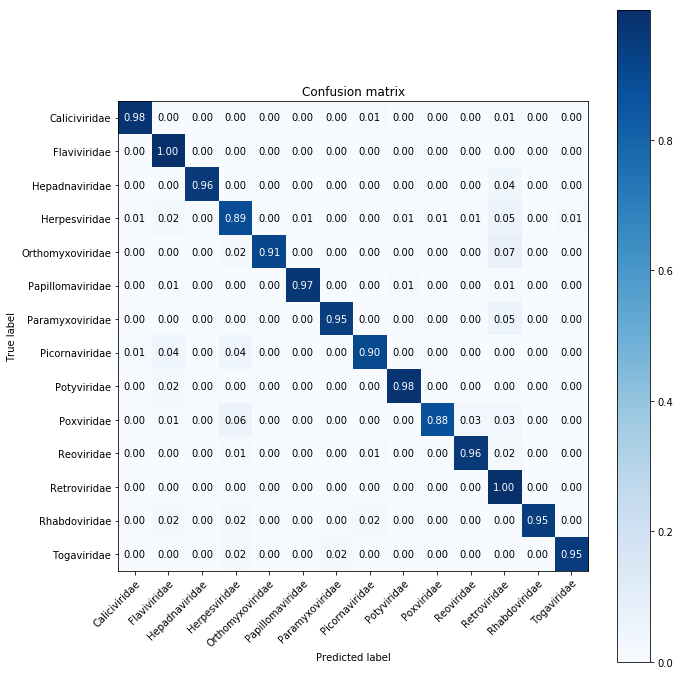

In [0]:
# Plot non-normalized confusion matrix
frequent_families = families.unique()
cm = plot_confusion_matrix(fams_test, test_prediction, classes=np.asarray(frequent_families), title='Confusion matrix')

Creating the n-grams of size 4 to 6

# Making the dataset for handling long sequences

In [0]:
sequence_max_size = 5000
filter= sequences.apply(lambda s: len(s) <= sequence_max_size)
sequences_ohs=sequences[filter].reset_index(drop=True)
families_ohs=families[filter].reset_index(drop=True)

print(f"Number of sequences of size < {sequence_max_size} : {len(families_ohs)}")
oh_fraction = len(families_ohs)/len(families)
print(f"{round(oh_fraction*100,2)}% of the original set")

Number of sequences of size < 5000 : 21479
93.59% of the original set


In [0]:
sequence_max_size = 5000
filter= sequences.apply(lambda s: len(s) > sequence_max_size)
sequences_ohl=sequences[filter].reset_index(drop=True)
families_ohl=families[filter].reset_index(drop=True)
print(f"Number of sequences of size > {sequence_max_size} : {len(families_ohl)}")
oh_fraction = len(families_ohl)/len(families)
print(f"{round(oh_fraction*100,2)}% of the original set")

Number of sequences of size > 5000 : 1470
6.41% of the original set


In [0]:
long_sequences=[]
long_sequences_families=[]
for s, sequence in enumerate(sequences_ohl):
  sub_sequences = [sequence[i:i+sequence_max_size] for i in range(0, len(sequence), sequence_max_size)]
  long_sequences.extend(sub_sequences)
  long_sequences_families.extend([families_ohl[s]]*len(sub_sequences))

print(f"Long sequences chunks to append : {len(long_sequences_families)}")
families_oh = families_ohs.append(pd.Series(long_sequences_families), ignore_index=True)
sequences_oh = sequences_ohs.append(pd.Series(long_sequences), ignore_index=True)
print(f"New dataset size : {len(sequences_oh)}")

Long sequences chunks to append : 5143
New dataset size : 26622


In [0]:
families_oh.value_counts()

Retroviridae        16354
Flaviviridae         2901
Poxviridae           2061
Herpesviridae        1538
Caliciviridae         598
Papillomaviridae      544
Reoviridae            468
Paramyxoviridae       417
Picornaviridae        359
Rhabdoviridae         306
Orthomyxoviridae      281
Togaviridae           272
Potyviridae           269
Hepadnaviridae        254
dtype: int64

# Classification _one-hot_

### Training the model

In [0]:
from sklearn.preprocessing import LabelBinarizer
import gc

linear_svm = []
encoded_sequences = []
sequences_ohs = []
families_ohs = []
sequences_ohl = []
families_ohl = []
long_sequences = []
long_sequences_families = []
seqs_train, seqs_test, fams_train, fams_test = ([], [], [], [])
gc.collect()

nuc_binarizer = LabelBinarizer()
nuc_binarizer.fit(["C","G","T","A"])
nuc_binarizer.classes_

array(['A', 'C', 'G', 'T'], dtype='<U1')

In [0]:
encoded_sequences = np.zeros((len(sequences_oh), sequence_max_size,4))
for s, sequence in enumerate(sequences_oh):
  encoded_sequences[s][:len(sequence)] = nuc_binarizer.transform(list(sequence))

dims = encoded_sequences.shape
encoded_sequences = encoded_sequences.reshape(dims[0],dims[1]*dims[2])

In [0]:
seqs_train, seqs_test, fams_train, fams_test = train_test_split(encoded_sequences, families_oh, test_size=0.2)
print(f"training size : {len(seqs_train)}")
print(f"test size : {len(seqs_test)}")

training size : 21297
test size : 5325


In [0]:
encoded_sequences=0
gc.collect()

10

In [0]:
linear_svm = LinearSVC(C=complexity, max_iter=5000, tol=1e-5)
linear_svm.fit(seqs_train, fams_train)


LinearSVC(C=0.05, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=None, tol=1e-05,
          verbose=0)

### Saving the model 

In [0]:
svm_oh_path = f"{project_path}/svm_oh.pkl"
svm_oh_file = open(svm_oh_path,"wb")
pickle.dump(linear_svm, svm_oh_file)

### Classifying

In [0]:
train_prediction = linear_svm.predict(seqs_train)
test_prediction= linear_svm.predict(seqs_test)

In [0]:
print(classification_report(fams_test, test_prediction))

                  precision    recall  f1-score   support

   Caliciviridae       0.95      0.88      0.91       112
    Flaviviridae       0.90      0.94      0.92       593
  Hepadnaviridae       0.98      0.84      0.90        49
   Herpesviridae       0.67      0.64      0.65       291
Orthomyxoviridae       0.96      0.93      0.94        54
Papillomaviridae       0.75      0.66      0.70        90
 Paramyxoviridae       0.79      0.75      0.77        84
  Picornaviridae       0.70      0.67      0.68        78
     Potyviridae       0.61      0.52      0.56        52
      Poxviridae       0.76      0.73      0.75       411
      Reoviridae       0.79      0.85      0.82       103
    Retroviridae       0.96      0.97      0.96      3299
   Rhabdoviridae       0.92      0.85      0.88        54
     Togaviridae       0.90      0.80      0.85        55

        accuracy                           0.90      5325
       macro avg       0.83      0.79      0.81      5325
    weighted

In [0]:
print(classification_report(fams_train, train_prediction))

                  precision    recall  f1-score   support

   Caliciviridae       1.00      1.00      1.00       486
    Flaviviridae       1.00      1.00      1.00      2308
  Hepadnaviridae       1.00      1.00      1.00       205
   Herpesviridae       1.00      1.00      1.00      1247
Orthomyxoviridae       1.00      1.00      1.00       227
Papillomaviridae       1.00      1.00      1.00       454
 Paramyxoviridae       1.00      1.00      1.00       333
  Picornaviridae       1.00      1.00      1.00       281
     Potyviridae       1.00      1.00      1.00       217
      Poxviridae       1.00      1.00      1.00      1650
      Reoviridae       1.00      1.00      1.00       365
    Retroviridae       1.00      1.00      1.00     13055
   Rhabdoviridae       1.00      1.00      1.00       252
     Togaviridae       1.00      1.00      1.00       217

        accuracy                           1.00     21297
       macro avg       1.00      1.00      1.00     21297
    weighted

Normalized confusion matrix


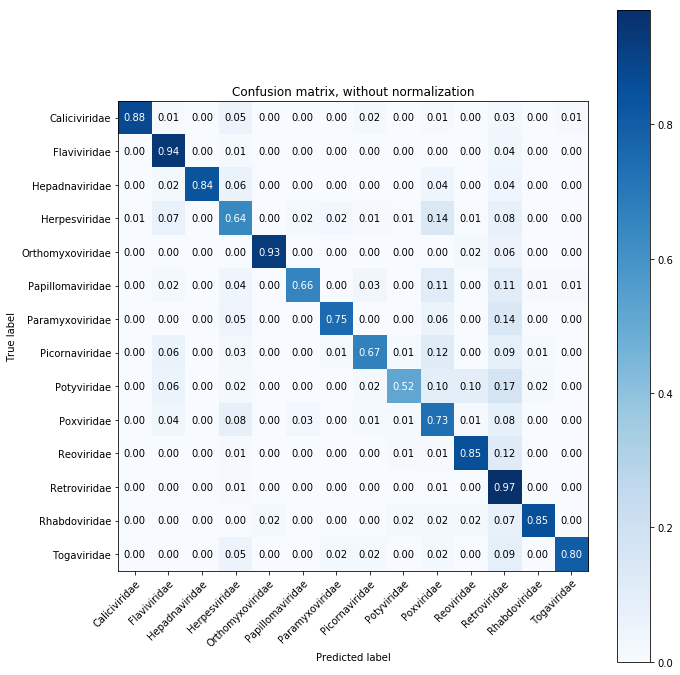

In [0]:
# Plot non-normalized confusion matrix
frequent_families=families_oh.unique()
cm = plot_confusion_matrix(fams_test, test_prediction, classes=np.asarray(frequent_families), title='Confusion matrix, without normalization')

# Classification _ordinal_

### Training the model

In [0]:
import gc
from sklearn.preprocessing import LabelEncoder

linear_svm = []
encoded_sequences = []
sequences_ohs = []
families_ohs = []
sequences_ohl = []
families_ohl = []
long_sequences = []
long_sequences_families = []
seqs_train, seqs_test, fams_train, fams_test = ([], [], [], [])
gc.collect()

nuc_encoder = LabelEncoder()
nuc_encoder.fit(["A", "C", "G", "T"])
nuc_encoder.classes_

array(['A', 'C', 'G', 'T'], dtype='<U1')

In [0]:
encoded_sequences = np.zeros((len(sequences_oh), sequence_max_size))
for s, sequence in enumerate(sequences_oh):
  encoded_sequences[s][:len(sequence)] = nuc_encoder.transform(list(sequence))

In [0]:
seqs_train, seqs_test, fams_train, fams_test = train_test_split(encoded_sequences, families_oh, test_size=0.2)
print(f"training size : {len(seqs_train)}")
print(f"test size : {len(seqs_test)}")

training size : 21297
test size : 5325


In [0]:
linear_svm = LinearSVC(C=complexity, max_iter=5000, tol=1e-5)
linear_svm.fit(seqs_train, fams_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.05, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=None, tol=1e-05,
          verbose=0)

### Saving the model 

In [0]:
svm_ie_path = f"{project_path}/svm_ie.pkl"
svm_ie_file = open(svm_ie_path,"wb")
pickle.dump(linear_svm, svm_ie_file)

### Classifying

In [0]:
train_prediction = linear_svm.predict(seqs_train)
test_prediction= linear_svm.predict(seqs_test)

In [0]:
print(classification_report(fams_test, test_prediction))

                  precision    recall  f1-score   support

   Caliciviridae       0.86      0.86      0.86       118
    Flaviviridae       0.81      0.86      0.83       621
  Hepadnaviridae       0.92      0.86      0.89        57
   Herpesviridae       0.55      0.46      0.50       316
Orthomyxoviridae       0.89      0.83      0.86        58
Papillomaviridae       0.69      0.60      0.64       126
 Paramyxoviridae       0.76      0.69      0.72        97
  Picornaviridae       0.52      0.57      0.54        60
     Potyviridae       0.57      0.48      0.52        54
      Poxviridae       0.63      0.64      0.63       420
      Reoviridae       0.79      0.79      0.79        96
    Retroviridae       0.92      0.92      0.92      3193
   Rhabdoviridae       0.74      0.87      0.80        45
     Togaviridae       0.78      0.84      0.81        64

        accuracy                           0.84      5325
       macro avg       0.74      0.73      0.74      5325
    weighted

In [0]:
print(classification_report(fams_train, train_prediction))

                  precision    recall  f1-score   support

   Caliciviridae       1.00      0.99      1.00       480
    Flaviviridae       0.93      0.95      0.94      2280
  Hepadnaviridae       1.00      0.99      0.99       197
   Herpesviridae       0.99      0.92      0.96      1222
Orthomyxoviridae       1.00      1.00      1.00       223
Papillomaviridae       0.99      0.96      0.98       418
 Paramyxoviridae       1.00      0.97      0.98       320
  Picornaviridae       1.00      0.92      0.96       299
     Potyviridae       1.00      0.97      0.98       215
      Poxviridae       1.00      0.98      0.99      1641
      Reoviridae       1.00      1.00      1.00       372
    Retroviridae       0.98      0.99      0.99     13161
   Rhabdoviridae       1.00      0.99      0.99       261
     Togaviridae       1.00      1.00      1.00       208

        accuracy                           0.98     21297
       macro avg       0.99      0.97      0.98     21297
    weighted

Normalized confusion matrix


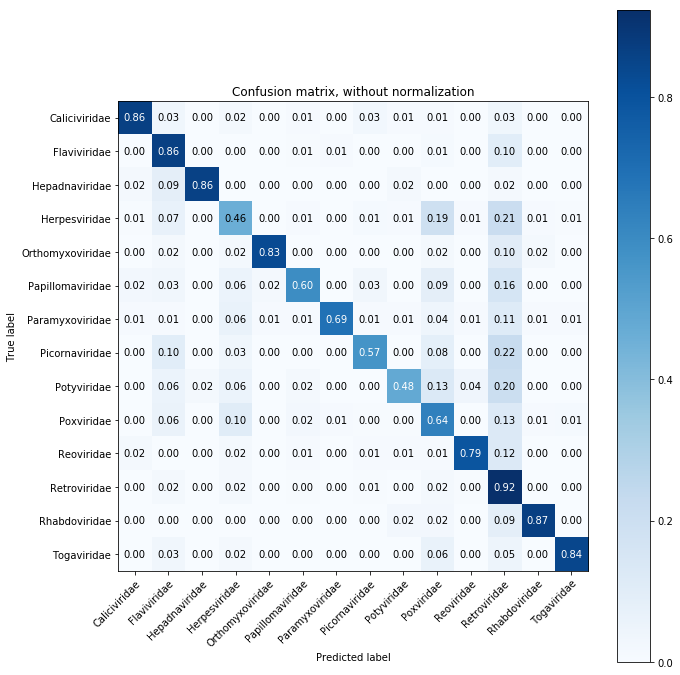

In [0]:
# Plot non-normalized confusion matrix
frequent_families=families_oh.unique()
cm = plot_confusion_matrix(fams_test, test_prediction, classes=np.asarray(frequent_families), title='Confusion matrix, without normalization')